# Visualize and Evaluate model

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
pip install pytorch-ignite

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install torch-lr-finder

Note: you may need to restart the kernel to use updated packages.


In [4]:
%matplotlib inline
import argparse
import os
from os.path import isfile,join
import random
import torch
import torch.nn as nn
import torchvision
from torchvision import models
import torch.utils.data as tud
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.utils as vutils
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from collections import Counter
from sklearn.metrics import jaccard_score
import pickle
import sys
sys.path.insert(1, '../utils')
sys.path.insert(1, '../datasets')
sys.path.insert(1, '../utils_on_gpu')
sys.path.insert(1, '../models')

import coco_utils as cu
import my_datasets as mdset
import eval_train as ev
import utils as U
import find_best_model as fbm   




## Parameters

In [5]:
# DATASETS
dataroot_voc = '~/data/voc2012'
dataroot_sbd = '~/data/sbd'
dataroot_coco = '/share/DEEPLEARNING/datasets/coco'
dataroot_landcover = '/home/joao/Documents/Landcover/landcover.ai'
dataroot_coco2voc = '/users/k/karmimy/data/coco2voc'
VOC = False

nw = 4 
pm = True
#MODEL SAVE AND LOAD 
load_dir = '/home/joao/Documents/FCN' # Saved model dir
exp = 'fully_supervised_lc'
model_name = 'fcn_fully_sup_lc.pt'
folder_model = join(load_dir,exp) 
#fcn= True
#pretrained=True

# GPU 
gpu = 1
# EVAL PARAMETERS
bs = 2  

# LOSS 
criterion_supervised = nn.CrossEntropyLoss(ignore_index=21) # On ignore la classe border.
Loss = 'CE' # Loss = 'KL' or 'CE' or None for L1,MSE…
#criterion_unsupervised = U.get_criterion(Loss)



# SEARCH FOR A PARTICULAR MODEL 
rotate = False # random rotation during training
scale = True
split = False # split the supervised dataset
ratio = 0.3
batch_size = 4

#scale_factor = (0.2,0.8)
#size_img = (420,420) 
#size_crop = (380,380)

# DEVICE
# Decide which device we want to run on
device = torch.device("cuda:"+str(gpu) if torch.cuda.is_available() else "cpu")
print("device :",device)

device : cpu


In [6]:
model_dir = '/home/joao/Documents/FCN/FCN/3'
#model_dir,_ = fbm.find_best_model_(folder=folder_model,split=split,batch_size=batch_size,rotate=False)

In [7]:
model = torch.load(join(model_dir,model_name), map_location=torch.device('cpu'))
model.to(device)

FCN16s(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(100, 100))
  (relu1_1): ReLU(inplace=True)
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_2): ReLU(inplace=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_1): ReLU(inplace=True)
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_2): ReLU(inplace=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_1): ReLU(inplace=True)
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_2): ReLU(inplace=True)
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_3): ReLU(inplace=True)
  (pool3): MaxPool2d(kernel_size=

## DATASETS

In [8]:
if VOC : 
        train_dataset_VOC = mdset.VOCSegmentation(dataroot_voc,year='2012', image_set='train',
                download=True,rotate=rotate,scale=scale,size_img=size_img,size_crop=size_crop)
        test_dataset = mdset.VOCSegmentation(dataroot_voc,year='2012', image_set='val', download=True)
        train_dataset_SBD = mdset.SBDataset(dataroot_sbd, image_set='train_noval',mode='segmentation',
                rotate=rotate,scale=scale,size_img=size_img,size_crop=size_crop)
        train_dataset = tud.ConcatDataset([train_dataset_VOC,train_dataset_SBD])
else:
        print('Loading Landscape Dataset')
        train_dataset = mdset.LandscapeDataset(dataroot_landcover,image_set="train",
            rotate=rotate)#,size_img=size_img,size_crop=size_crop)
        test_dataset = mdset.LandscapeDataset(dataroot_landcover,image_set="test")
        test_dataset_no_norm =  mdset.LandscapeDataset(dataroot_landcover,image_set="test",normalize=False)
        print('Success load Landscape Dataset')
dataloader_train = torch.utils.data.DataLoader(train_dataset, batch_size=bs,num_workers=nw,
        pin_memory=pm,shuffle=True,drop_last=True)#,collate_fn=U.my_collate)
dataloader_val = torch.utils.data.DataLoader(test_dataset,num_workers=nw,pin_memory=pm,
        batch_size=bs)


Loading Landscape Dataset
Success load Landscape Dataset


## Plot Losses and Metrics 

In [9]:
def plot_loss_metrics(folder,model_name):
    l_npy = [f for f in os.listdir(folder) if isfile(join(folder,f)) and f.endswith(".npy")] # Load all numpy file in the best folder
    for f in l_npy:
        curv = np.load(join(model_dir,f))
        plt.figure(figsize=(10,8))
        plt.subplot(2,1,1)
        plt.title(model_name.upper())
        plt.plot(curv)
        plt.xlabel("iterations")
        plt.ylabel(f.upper())



In [10]:
plot_loss_metrics(model_dir,model_name)

## SHOW MODEL PREDICTIONS

In [13]:
# PARAMETERS FOR THE VISUALIZATION
all_imgs = len(test_dataset)
NUMBER_EXAMPLES = all_imgs
#NUMBER_EXAMPLES = 20
list_iter = np.random.randint(0,len(test_dataset),NUMBER_EXAMPLES) # TAKE N RANDOM IMAGES 
CLASS = U.LANDCOVER_CLASS
CMAP = U.get_cmap_landcover()

ITERATION 0 / 1602
Metrics on this example... IoU: 0.46825599670410156 Accuracy 0
ITERATION 1 / 1602
Metrics on this example... IoU: 0.10784149169921875 Accuracy 0
ITERATION 2 / 1602
Metrics on this example... IoU: 0.21317036946614584 Accuracy 0
ITERATION 3 / 1602
Metrics on this example... IoU: 0.2427692413330078 Accuracy 0
ITERATION 4 / 1602
Metrics on this example... IoU: 0.39385223388671875 Accuracy 0
ITERATION 5 / 1602
Metrics on this example... IoU: 0.48441123962402344 Accuracy 0
ITERATION 6 / 1602
Metrics on this example... IoU: 1.0 Accuracy 1
ITERATION 7 / 1602
Metrics on this example... IoU: 0.33751869201660156 Accuracy 0
ITERATION 8 / 1602
Metrics on this example... IoU: 0.29625892639160156 Accuracy 0
ITERATION 9 / 1602
Metrics on this example... IoU: 0.04336675008138021 Accuracy 0
ITERATION 10 / 1602
Metrics on this example... IoU: 0.42986488342285156 Accuracy 0
ITERATION 11 / 1602
Metrics on this example... IoU: 0.029424667358398438 Accuracy 0
ITERATION 12 / 1602
Metrics on

/home/joao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()


Metrics on this example... IoU: 0.16422017415364584 Accuracy 0
ITERATION 21 / 1602
Metrics on this example... IoU: 1.0 Accuracy 1
ITERATION 22 / 1602
Metrics on this example... IoU: 0.49675941467285156 Accuracy 0
ITERATION 23 / 1602
Metrics on this example... IoU: 0.31290245056152344 Accuracy 0
ITERATION 24 / 1602
Metrics on this example... IoU: 1.0 Accuracy 1
ITERATION 25 / 1602
Metrics on this example... IoU: 1.0 Accuracy 1
ITERATION 26 / 1602
Metrics on this example... IoU: 0.2805156707763672 Accuracy 0
ITERATION 27 / 1602
Metrics on this example... IoU: 0.3094584147135417 Accuracy 0
ITERATION 28 / 1602
Metrics on this example... IoU: 0.41979217529296875 Accuracy 0
ITERATION 29 / 1602
Metrics on this example... IoU: 0.012781143188476562 Accuracy 0
ITERATION 30 / 1602
Metrics on this example... IoU: 0.4464702606201172 Accuracy 0
ITERATION 31 / 1602


KeyboardInterrupt: 

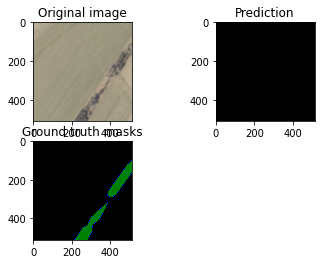

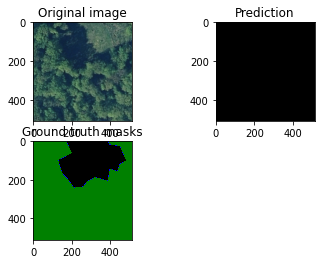

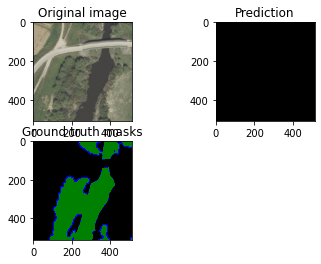

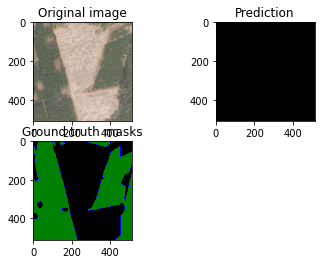

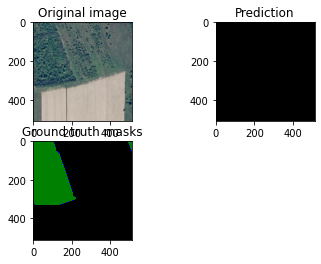

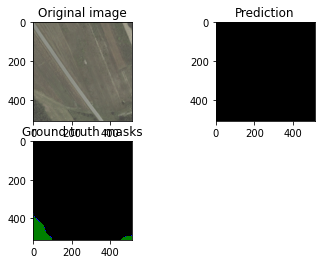

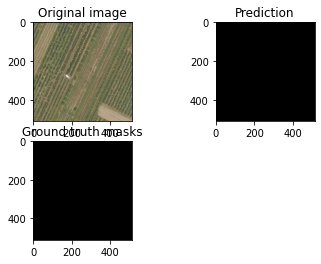

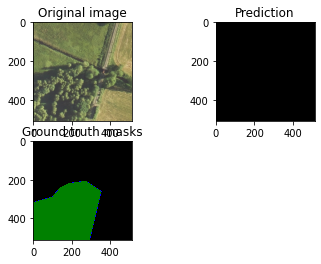

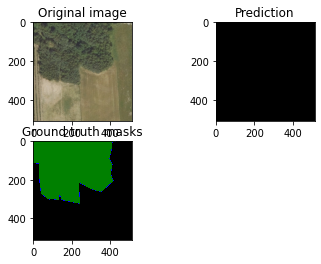

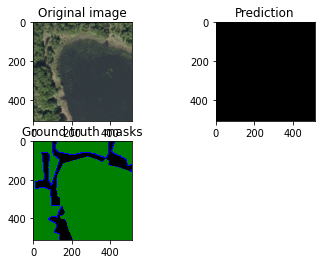

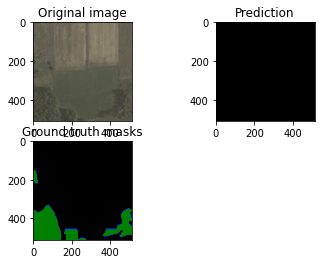

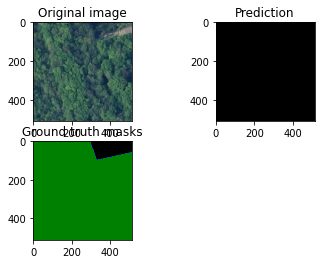

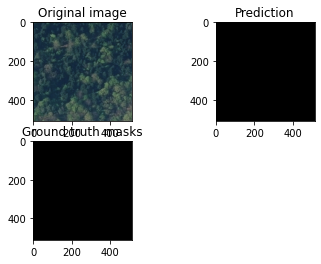

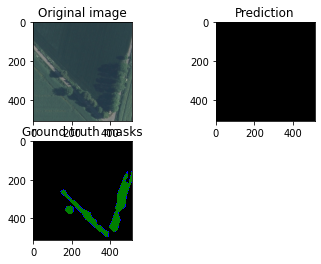

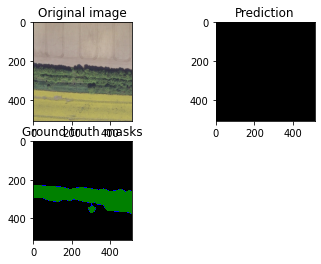

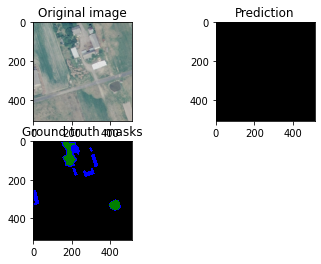

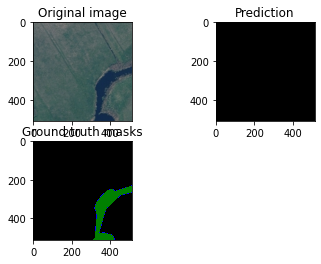

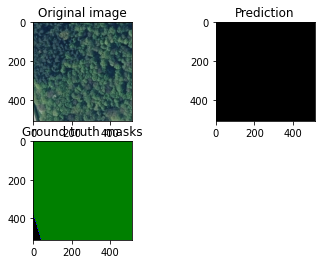

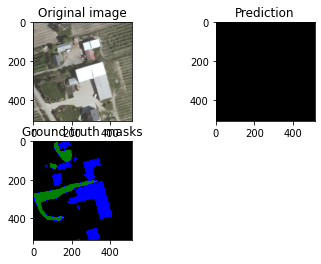

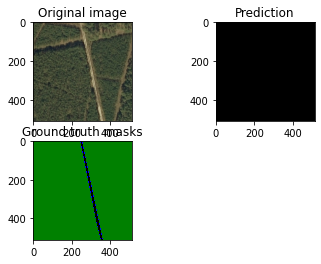

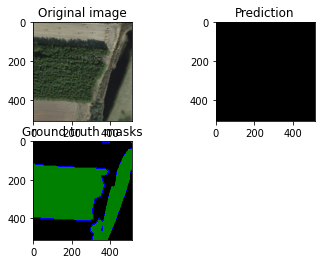

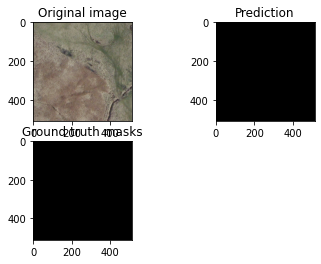

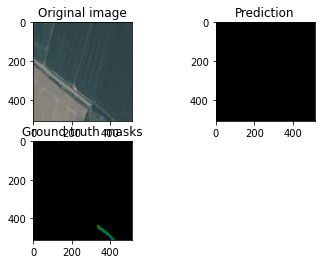

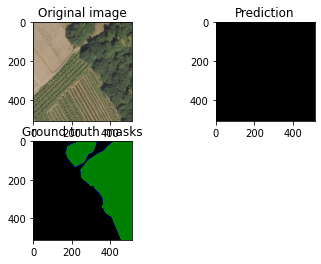

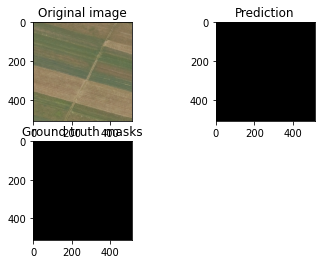

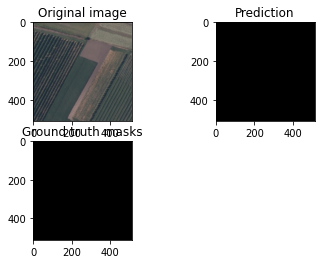

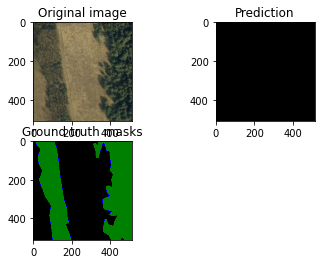

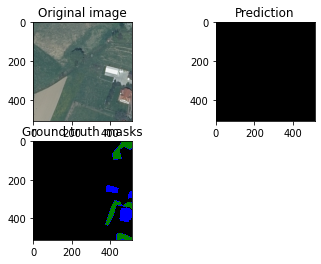

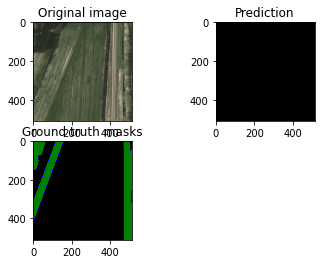

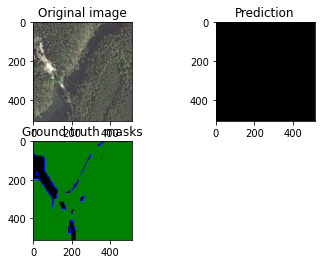

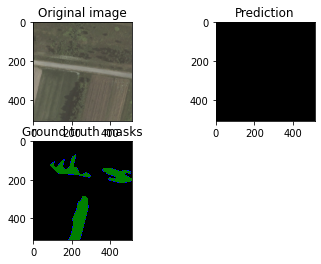

In [14]:
model.eval()
l_iou=[]
l_acc=[]
for i,im in enumerate(list_iter):
    print('ITERATION',i,'/',NUMBER_EXAMPLES)
    x,gt = test_dataset.__getitem__(im)
    im,_ = test_dataset_no_norm.__getitem__(im)
    x = x.unsqueeze(0).to(device)
    pred = model(x)
    #pred = pred['out']

    #plot
    im = torch.transpose(im,0,2)
    im = torch.transpose(im,0,1)
    pred = pred.argmax(dim=1).squeeze().cpu().detach()
    fig = plt.figure()
    ax1 = fig.add_subplot(2,2,1)
    ax1.title.set_text('Original image')
    ax1.imshow(im.cpu(),cmap=CMAP)
    ax2 = fig.add_subplot(2,2,2)
    ax2.title.set_text('Prediction')
    ax2.imshow(pred,cmap=CMAP)
    ax3 = fig.add_subplot(2,2,3)
    ax3.title.set_text('Ground truth masks')
    ax3.imshow(gt.cpu(),cmap=CMAP)
    
    # Metrics 
    iou = U.inter_over_union(pred,gt)
    acc = int(torch.sum(pred==gt)/(pred.size()[0]*pred.size()[1]))
    l_iou.append(iou)
    l_acc.append(acc)
    print("Metrics on this example... IoU:",iou,"Accuracy",acc)
print("Mean IoU",np.array(l_iou).mean(),"Mean Accuracy",np.array(l_acc).mean())